# Evaluating the churn prediction project

# 4. Evaluation metrics for classification

In the last chapter we made a model to predict whether customers will churn, and we concluded that it had 80% accurary. Here, we will see if 80% accurary is good enough, and discuss other ways of evaluating a binaru classification model: the confusion table, precision and recall, the ROC curve, and AUC.

Don’t worry if you don’t immediately understand all the details of the different evaluation metrics: it requires time and practice. Feel free to come back to this chapter to revisit the finer points.

Let's bring in the model from last chapter so we have the data for this chapter.

In [200]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [202]:
df = pd.read_csv("../chapter3_machine_learning_for_classification/Telco-Customer-Churn.csv")

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)

df.columns = df.columns.str.lower().str.replace(" ", "_")
string_columns = list(df.dtypes[df.dtypes == "object"].index)
for column in string_columns:
    df[column] = df[column].str.lower().str.replace(" ", "_")

df.churn = (df.churn == "yes").astype(int)

In [203]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train["churn"]
del df_val["churn"]

In [204]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [205]:
train_dict = df_train[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [206]:
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [207]:
val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [208]:
subset = ["contract", "tenure", "totalcharges"]
train_dict_small = df_train[subset].to_dict(orient="records")
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver="liblinear", random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [209]:
val_dict_small = df_val[subset].to_dict(orient="records")
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

## 4.1. Evaluation metrics

We have already built a binary classificatino model for predicting churning customers. Now we need to be able to determine how good it is.

For this, we use a metric-a function that looks at the predictions the model makes and compares them with the actual values. Then, based on the comparison, it calculates how good the model is. This is quite useful: we can use it to compare different models and select the one with the best metric value.

There are different kinds of metrics. In chapter 2, we used RMSE (root mean squared error) to evaluate regression models. However, this metric can be used only for regression models and doesn’t work for classification.

For evaluating classification models, we have other more suitable metrics. In this section, we cover the most common evaluation metrics for binary classification, starting with accuracy, which we already saw in chapter 3.

### 4.1.1. Classification accuracy

The accuracy of a binary classification model is the percentage of correct predictions it makes.

This accuracy is the simplest way to evaluate a classifier: by counting the number of cases in which our model turned out to be right, we can learn a lot about the model's behavior and quality.

Computing accuracy on the validation dataset is easy—we simply calculate the fraction of correct predictions.

In [210]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

np.float64(0.8016129032258065)

The result is 0.8016, which means that our model is 80% accurate.

One thing we should ask ourselves is how we choose a specific value for a threshold and not any other number. This is an arbitrary choice, but it’s actually not difficult to check other thresholds as well: we can just loop over all possible threshold candidates and compute the accuracy for each. Then we can choose the one with the best accuracy score.

Even though it’s easy to implement accuracy ourselves, we can use existing implementations as well. The Scikit-learn library offers a variety of metrics, including accuracy and many others that we will use later. You can find these metrics in the metrics package:

In [211]:
from sklearn.metrics import accuracy_score

In [212]:
accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

Now we can loop over different thresholds and check which one gives the best accuracy:

In [213]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for threshold in thresholds:
    accuracy = accuracy_score(y_val, y_pred >= threshold)
    accuracies.append(accuracy)
    print("%0.2f %0.3f" % (threshold, accuracy))

0.00 0.261
0.05 0.501
0.10 0.595
0.15 0.640
0.20 0.690
0.25 0.730
0.30 0.755
0.35 0.767
0.40 0.782
0.45 0.795
0.50 0.802
0.55 0.790
0.60 0.790
0.65 0.788
0.70 0.774
0.75 0.752
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


As we see, using the threshold of 0.5 gives us the best accuracy. Typically, 0.5 is a good threshold value to start with, but we should always try other threshold values to make sure 0.5 is the best choice.

To make it more visual, we can use Matplotlib to create a plot that shows how accuracy changes depending on the threshold:

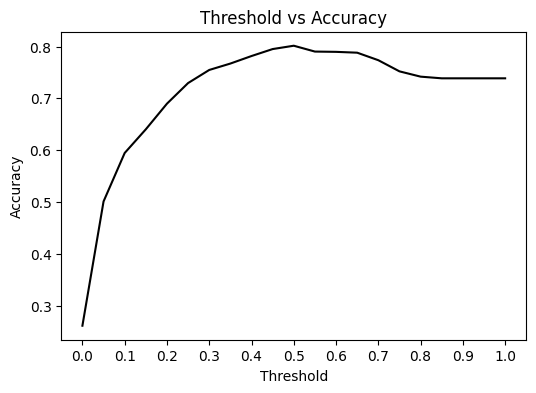

In [214]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color="black")

plt.title("Threshold vs Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

plt.xticks(np.linspace(0, 1, 11))

plt.show()

After executing this line, we should see a plot that shows the relationship between the threshold and the accuracy. As we already know, the 0.5 threshold is the best in terms of accuracy, and the best accuracy for this model that we can achieve is 80%.

In the previous chapter, we trained a simpler model: we called it model_small. It was based on only three variables: contract, tenure, and totalcharges. Let's also check its accuracy. For that, we first make predictions on the validation dataset and then compute the accuracy score:

In [215]:
churn_small = y_pred_small >= 0.5
accuracy_score(y_val, churn_small)

0.7672043010752688

When we runt his code, we see that the accuracy of the small model is 76%. So, the large model is actually 4% more accurate than the small model.

However, this still doesn’t tell us whether 80% (or 76%) is a good accuracy score.

### 4.1.2. Dummy baseline

Although it seems like a decent number, to understand whether 80% is actually good, we need to relate it to something-for example, a simple baseline that's easy to understand. One such baseline could be a dummy model that always predicts the same value.

In our example, the dataset is imbalanced, and we don’t have many churned users. So, the dummy model can always predict the majority class—“no churn.” In other words, this model will always output False, regardless of the features. This is not a super useful model, but we can use it as a baseline and compare it with the other two models.

In [216]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False], shape=(1860,))

To create an array with the baseline predictions, we first need to determine how many elements are in the validation set. Next, we create an array of dummy predictions-all the elements of this array are False values. We do this using the repeat function from NumPy: it takes in an element and repeats it as many times as we ask.

Now we can check the accuracy of this baseline prediction using the same code as before:

In [217]:
accuracy_score(baseline, y_val)

0.7387096774193549

When we run this code, it shows 0.739. This means that the accuracy of the baseline model is around 74%.

The small model is only 2% better than the naive baseline, and the large one is 6% better. If we think about all the trouble we have gone through to train this large model, 6% doesn’t seem like a significant improvement over the dummy baseline.

Metrics that we can use to measure the quallity of a model are based on the confusion table.

## 4.2. Confusion table

Even though accuracy is easy to understand, it’s not always the best metric. In fact, it sometimes can be misleading. We’ve already seen this occur: the accuracy of our model is 80%, and although that seems like a good number, it’s just 6% better than the accuracy of a dummy model that always outputs the same prediction of “no churn.”

This situation typically happens when we have a class imbalance. We know that this is the case for our problem because 74% of customers did not churn, and only 26% did churn.

The confusion table is a table that concisely represents every possible outcome for a model's predictions.

### 4.2.1. Introduction to the confusion table

We know that for a binary classification model, we can have only two possible predictions: True and False. In our case, we can predict that a customer is either going to churn (True) or not (False).

When we apply the model to the entire validation dataset with customers we split it into customers for whom the model predicts "churn", and customers for whom the model predicts "no churn".

Only two possible correct outcomes can occur: again, True or False. A customer has either actually churned (True) or not (False).

This means that by using the ground truth information—the information about the target variable—we can again split the dataset into two parts, the customers who churned, and the customers who didn't churn.

When we make a prediction, it will either turn out to be correct or not:

- If we predict “churn,” the customer may indeed churn, or they may not.
- If we predict “no churn,” it’s possible that the customer indeed doesn’t churn, but it’s also possible that they do churn.

This gives us four possible outcomes:

- We predict False, and the answer is False.
- We predict False, and the answer is True.
- We predict True, and the answer is False.
- We predict True, and the answer is True.

Two of these situations-the first and last ones-are good: the prediction matched the actual value. The two remaining ones are bad: we didn't make a correct prediction.

Each of these four situations has its own name:

- True negative (TN): we predict False (“no churn”), and the actual label is also False (“no churn”).
- True positive (TP): we predict True (“churn”), and the actual label is True (“churn”).
- False negative (FN): we predict False (“no churn”), but it’s actually True (the customer churned).
- False positive (FP): we predict True (“churn”), but it’s actually False (the customer stayed with us).

We can visualize these outcomes in a table, with the predicted classes in the columns and the actual classes in the rows. When we substitute the number of times each outcome happens, we get the confusion table for our model.

### 4.2.2. Calculating the confusion table with NumPy

To calculate the confusion table, we need to do these steps:

- First, the predictions split the dataset into two parts: the part for which we predict True (“churn”) and the part for which we predict False (“no churn”).
- At the same time, the target variable splits this dataset into two different parts: the customers who actually churned (“1” in y_val) and the customers who didn’t (“0” in y_val).
- When we combine these splits, we get four groups of customers, which are exactly the four different outcomes from the confusion table.

Translating these steps to NumPy is straightforward:

In [218]:
threshold = 0.5

predict_churn = (y_pred >= threshold)
predict_no_churn = (y_pred < threshold)
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()

Now we just need to put all these values together in a NumPy array:

In [219]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1202,  172],
       [ 197,  289]])

The absolute numbers may be difficult to understand, so we can turn them into fractions by dividing each value by the total number of items:

In [220]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

We see that the model predicts negative values quite well: 65% of the predictions are true negatives. However, it makes quite a few mistakes of both types: the number of false positives and false negatives is roughly equal (9% and 11%, respectively).

This table gives us a better understanding of the performance of the model—it’s now possible to break down the performance into different components and understand where the model makes mistakes. We actually see that the performance of the model is not great: it makes quite a few errors when trying to identify users that will churn. This is something we couldn’t see with the accuracy score alone.

### 4.2.3. Precision and recall

Accuracy can be misleading when dealing with imbalanced datasets like the one in this problem. Other metrics are helpful to use for such cases: precision and recall.

Both precision and recall are calculated from the values of the confusion table. They both help us understand the quality of the model in cases of class imbalance.

The precision of a model tells us how many of the positive predictions turned out to be correct. It’s the fraction of correctly predicted positive examples. In our case, it’s the number of customers who actually churned (TP) out of all the customers we thought would churn (TP + FP).

Precision = true_positive / (true_positive + false_positive)

In [221]:
true_positive / (true_positive + false_positive)

np.float64(0.6268980477223427)

For our model, the precision is 62%.

Recall is the fraction of correct classified positive examples among all positive examples. In our case, to calculate recall we first look at all the customers who churned and see how many of them we managed to identify correctly.

Recall = true_positive / (true_positive + false_negative)

In [222]:
true_positive / (true_positive + false_negative)

np.float64(0.5946502057613169)

For our model, the recall is 59%.

The difference between precision and recall may seem subtle at first. In both cases, we look at the number of correct predictions, but the difference is in the denominators:

- Precision: what’s the percent of correct predictions (TP) among customers predicted as churning (TP + FP)?
- Recall: what’s the percentage correctly predicted as churning (TP) among all churned customers (TP + FN)?

We see that both precision and recall don't take true negatives into account. This is exactly why they are good evaluation metrics for imbalanced datasets. For situations with class imbalanace, true negatives typically outnumber everything else-but at the same time, they are also often not really interesting for us.

The goal of our project is to identify customers who are likely to churn. Once we do, we can send them promotional messages in the hopes that they’ll change their mind.

When doing this, we make two types of mistakes:

- We accidentally send messages to people who weren’t going to churn—these people are the false positives of the model.
- We also sometimes fail to identify people who are actually going to churn. We don’t send messages to these people—they are our false negatives.

Precision and recall help us quantify these errors.

Precision helps us understand how many people received a promotional message by mistake. The better the precision, the fewer false positives we have. The precision of 62% means that 62% of the reached customers indeed were going to churn (our true positives), whereas the remaining 38% were not (false positives).

Recall helps us understand how many of the churning customers we failed to find. The better the recall, the fewer false negatives we have. The recall of 59% means that we reach only 59% of all churning users (true positives) and fail to identify the remaining 41% (false negatives).

In both cases, we don't really need to know the number of true negatives: even though we can correctly identify them as not churning, we aren't going to do anything with them.

Although the accuracy of 80% might suggest that the model is great, looking at its precision and recall tells us that it actually makes quite a few errors. This is typically not a deal-breaker: with machine learning it’s inevitable that models make mistakes, and at least now we have a better and more realistic understanding of the performance of our churn-prediction model.

## 4.3. ROC curve and AUC score

The metrics we have covered so far work only with binary predictions—when we have only True and False values in the output. However, we do have ways to evaluate the performance of a model across all possible threshold choices. ROC curves is one of these options.

ROC stands for "receiver operating characteristic," and it was initially designed for evaluating the strength of radar detectors during World War II. It was used to assess how well a detector could separate two signals: whether an airplane was there or not. Nowadays it's used for a similar purpose: it shows how well a model can separate two classes, positive and negative. In our case, these classes are "churn" and "no churn."

We need two metrics for ROC curves: TPR and FPR, or true positive rate and false positive rate. Let’s take a look at these metrics.

### 4.3.1. True positive rate and false positive rate

The ROC curve is based on two quantities, FPR and TPR;

- False positive rate (FPR): the fraction of false positives among all negative examples
- True positive rate (TPR): the fraction of true positives among all positive examples

Like precisioin and recall, these values are based on the confusion matrix.

False positive rate = false_positive / (false_positive + true_negative)

True positive rate = true_positive / (true_positive + false_negative)

In [223]:
false_positive / (false_positive + true_negative)

np.float64(0.12518195050946143)

FPR is the fraction of users we predicted as churning among evverybody who didn't churn. A small value ofr FPR tells us that a model is good-it has few false positives.

In [224]:
true_positive / (true_positive + false_negative)

np.float64(0.5946502057613169)

TPR is the fraction of users who we predicted as churning among everybody who actually did churn. Note that TPR is the same as recall, so the higher the TPR is, the bette.

However, we still consider FPR and TPR metrics at only one threshold value—in our case, 0.5. To be able to use them for ROC curves, we need to calculate these metrics for many different threshold values.


### 4.3.2. Evaluating a model at multiple thresholds

Binary classification models, such as logistic regression, typically output a probability-a score between zero and one. To make actual predictions, we binarize the output by setting some threshold to get only True and False values.

Instead of evaluating the model at one particular threshold, we can do it for a range of them-in the same way we did it for accuracy earlier in this chapter.

Let's iterate over different threshold values and compute the values of the confusion table for each:

In [225]:
scores = []

thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    true_positive = ((y_pred >= threshold) & (y_val == 1)).sum()
    false_positive = ((y_pred >= threshold) & (y_val == 0)).sum()
    false_negative = ((y_pred < threshold) & (y_val == 1)).sum()
    true_negative = ((y_pred < threshold) & (y_val == 0)).sum()
    scores.append((threshold, true_positive, false_positive, false_negative, true_negative))

It's not easy to deal with a list of tuples, so let's convert it to a Pandas dataframe:

In [226]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ["threshold", "true_positive", "false_positive", "false_negative", "true_negative"]

In [227]:
df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


Now we can compute the TPR and FPR scores. Because the data is now in a dataframe, we can do it for all the values at once:

In [228]:
df_scores["true_positive_rate"] = df_scores["true_positive"] / (df_scores["true_positive"] + df_scores["false_negative"])
df_scores['false_positive_rate'] = df_scores["false_positive"] / (df_scores["false_positive"] + df_scores["true_negative"])

In [229]:
df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,true_positive_rate,false_positive_rate
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


Let’s plot them:

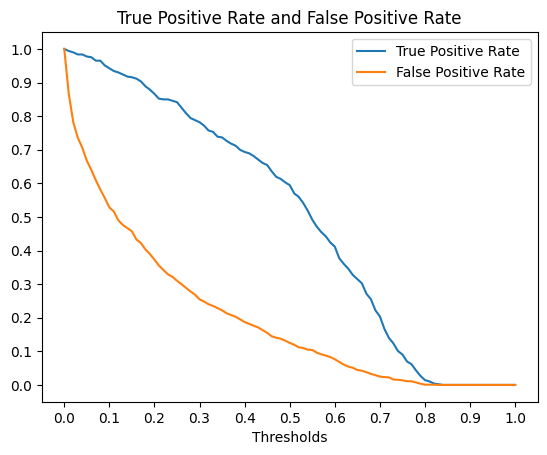

In [230]:
plt.plot(df_scores.threshold, df_scores["true_positive_rate"], label="True Positive Rate")
plt.plot(df_scores.threshold, df_scores["false_positive_rate"], label="False Positive Rate")
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel("Thresholds")
plt.title("True Positive Rate and False Positive Rate")

plt.show()

Both TPR and FPR start at 100%—at the threshold of 0.0, we predict “churn” for everyone:

- FPR is 100% because we have only false positives in the prediction. There are no true negatives: nobody is predicted as non-churning.
- TPR is 100% because we have only true positives and no false negatives.

As the threshold grows, both metrics decline but at different rates.

Ideally, FPR should go down very quickly. A small FPR indicates that the model makes very few mistakes predicting negative examples (false positives).

On the other hand, TPR should go down slowly, ideally staying near 100% all the time: that will mean that the model predicts true positives well.

To better understand what these TPR and FPR mean, let's compare it with two baseline models: a random model and the ideal model. We will start with a random model.

### 4.3.3. Random baseline model

A random model outputs a random score between 0 and 1, regardless of the input. It’s easy to implement—we simply generate an array with uniform random numbers:

In [231]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

Now we can pretend that y_rand contains the predictions of our "model".

Let's calculate FPR and TPR for our random model. To make it simpler, we'll reuse the code we wrote previously and put it into a function.

In [232]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for threshold in thresholds:
        true_positive = ((y_pred >= threshold) & (y_val == 1)).sum()
        false_positive = ((y_pred >= threshold) & (y_val == 0)).sum()
        false_negative = ((y_pred < threshold) & (y_val == 1)).sum()
        true_negative = ((y_pred < threshold) & (y_val == 0)).sum()
        scores.append((threshold, true_positive, false_positive, false_negative, true_negative))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ["threshold", "true_positive", "false_positive", "false_negative", "true_negative"]

    df_scores["true_positive_rate"] = df_scores["true_positive"] / (df_scores["true_positive"] + df_scores["false_negative"])
    df_scores['false_positive_rate'] = df_scores["false_positive"] / (df_scores["false_positive"] + df_scores["true_negative"])

    return df_scores

Now let’s use this function to calculate the TPR and FPR for the random model:

In [233]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,true_positive_rate,false_positive_rate
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


Let's plot them:

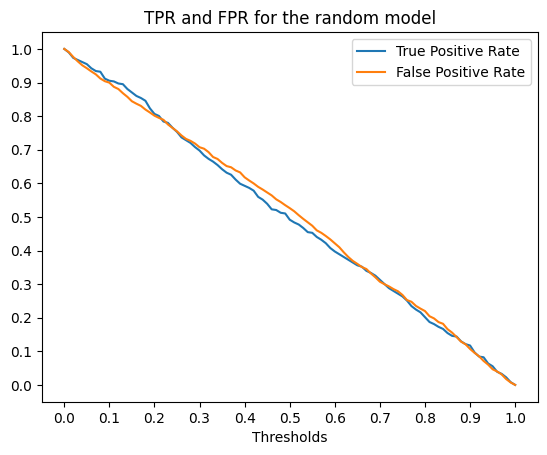

In [234]:
plt.plot(df_rand["threshold"], df_rand["true_positive_rate"], label="True Positive Rate")
plt.plot(df_rand["threshold"], df_rand["false_positive_rate"], label="False Positive Rate")
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel("Thresholds")
plt.title("TPR and FPR for the random model")

plt.show()

We see that both TPR and FPR curves go from 100% to 0%, almost following the straight line.

At the threshold of 0.0, we treat everybody as churning. Both TPR and FPR are 100%:

- FPR is 100% because we have only false positives: all non-churning customers are identified as churning.
- TPR is 100% because we have only true positives: we can correctly classify all churning customers as churning.

As we increase the threshold, both TPR and FPR decrease.

At the threshold of 0.4, the model with a probability of 40% predicts “non-churn,” and with a probability of 60% predicts “churn.” Both TPR and FPR are 60%:

- FPR is 60% because we incorrectly classify 60% of non-churning customers as churning.
- TPR is 60% because we correctly classify 60% of churning customers as churning.

Finally, at 1.0, both TPR and FPR are 0%. At this threshold, we predict everybody as non-churning:

- FPR is 0% because we have no false positives: we can correctly classify all non-churning customers as non-churning.
- TPR is 0% because we have no true positives: all churning customers are identified as non-churning.

Let’s now move on to the next baseline and see how TPR and FPR look for the ideal model.

### 4.3.4. The ideal model

The ideal model always makes correct decisions. We’ll take it a step further and consider the ideal ranking model. This model outputs scores in such a way that churning customers always have higher scores than non-churning ones. In other words, the predicted probability for all churned ones should be higher than the predicted probability for non-churned ones.

So, if we apply the model to all the customers in our validation set and then sort them by the predicted probability, we first will have all the non-churning customers, followed by the churning ones.

Of course, we cannot have such a model in real life. It’s still useful, however: we can use it for comparing our TPR and FPR to the TPR and FPR of the ideal model.

Let's generate the ideal predictions. To make it easier, we generate an array with fake target variables that are already ordered: first it contains only 0s and then only 1s. As for "predictions," we simply can create an array with numbers that grow from 0 in the first cell to 1 in the alst cell using the np.linspace function.

num_neg + num_pos = 1860, so y_pred_ideal is an array from 0 in the first cell to 1 in the last cell, and each cell has a value that is (1 / 1859) greater than the cell before it.

In [235]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

# Generates an array that first repeats 0s num_neg number of times, followed by 1s repeated num_pos number of times
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
# Generates the predictions of the "model": numbers that grow from 0 in the first cell to 1 in the last
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,true_positive_rate,false_positive_rate
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


As a result, we get a dataframe with the TPR and FPR values of the ideal model.

Now we can plot it:

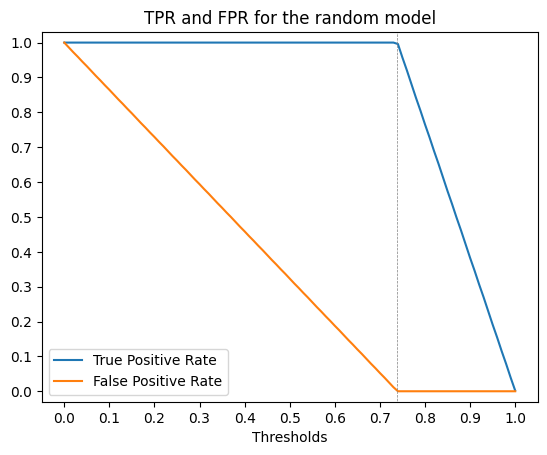

In [236]:
plt.plot(df_ideal["threshold"], df_ideal["true_positive_rate"], label="True Positive Rate")
plt.plot(df_ideal["threshold"], df_ideal["false_positive_rate"], label="False Positive Rate")
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle="dashed", color="grey")
plt.ylim(-0.03, 1.03)

plt.xlabel("Thresholds")
plt.title("TPR and FPR for the random model")

plt.show()

From the plot, we can see that

- Both TPR and FPR start at 100% and end at 0%.
- For thresholds lower than 0.74, we always correctly classify all churning customers as churning; that’s why TRP stays at 100%. On the other hand, we incorrectly classify some non-churning ones as churning—those are our false positives. As we increase the threshold, fewer and fewer non-churning customers are classified as churning, so FPR goes down. At 0.6, we misclassify 258 non-churning customers as churning.
- The threshold of 0.74 is the ideal situation: all churning customers are classified as churning, and all non-churning are classified as non-churning; that’s why TPR is 100% and FPR is 0%.
- Between 0.74 and 1.0, we always correctly classify all non-churning customers, so FPR stays at 0%. However, as we increase the threshold, we start incorrectly classifying more and more churning customers as non-churning, so TPR goes down. At 0.8, 114 out of 446 churning customers are incorrectly classified as non-churning. Only 372 predictictions are correct, so TPR is 76%.

### 4.3.5. ROC Curve

To create an ROC curve, instead of plotting FPR and TPR against differernt threshold values, we plot them against each other. For comparison, we also add the ideal and random models to the plot:

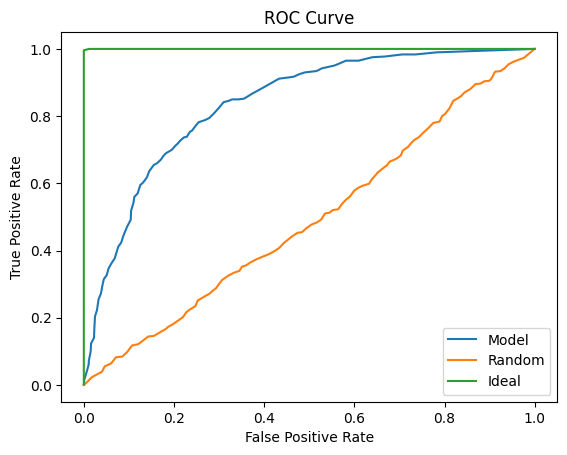

In [237]:
plt.plot(df_scores["false_positive_rate"], df_scores["true_positive_rate"], label="Model")
plt.plot(df_rand["false_positive_rate"], df_rand["true_positive_rate"], label="Random")
plt.plot(df_ideal["false_positive_rate"], df_ideal["true_positive_rate"], label="Ideal")

plt.legend()

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve")

plt.show()

When we plot the ROC curve, we can see that the ROC curve of the random classifier is an approximately straight line from bottom left to top right. For the ideal model, however, the curve first goes up until it reaches 100% TPR, and from there it goes right until it reaches 100% FPR.

Our models should always be somewhere between these two curves. We want our model to be as close to the ideal curve as possible and as far as possible from the random curve.

The ROC curve of a random model serves as a good visual baseline-when we add it to the plot, it helps us to judge how far our model is from this baseline-so it's a good idea to always include this line in the plot.

However, we don’t really need to generate a random model each time we want to have an ROC curve: we know what it looks like, so we can simply include a straight line from (0, 0) to (1, 1) in the plot.

As for the ideal model, we know that it always goes up to (0, 1) and then goes right to (1, 1). The top-left corner is called the “ideal spot”: it’s the point when the ideal model gets 100% TPR and 0% FPR. We want our models to get as close to the ideal spot as possible.

With this information, we can reduce the code for plotting the curve to the following:

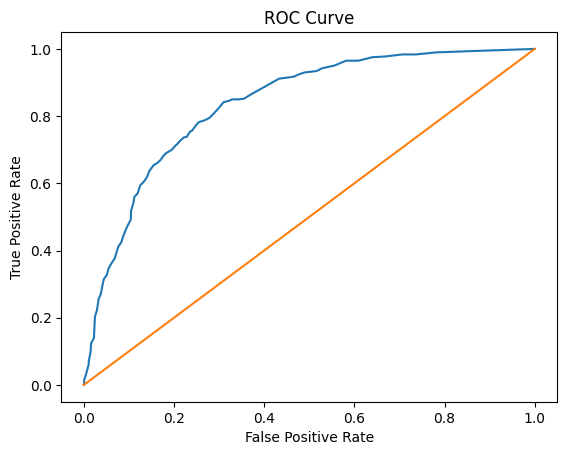

In [238]:
plt.plot(df_scores["false_positive_rate"], df_scores["true_positive_rate"])
plt.plot([0, 1], [0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve")

plt.show()

Although computing all the FPR and TPR values across many thresholds is a good exercise, we don’t need to do it ourselves every time we want to plot an ROC curve. We simply can use the roc_curve function from the metrics package of Scikit-learn:

In [239]:
from sklearn.metrics import roc_curve

In [240]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)

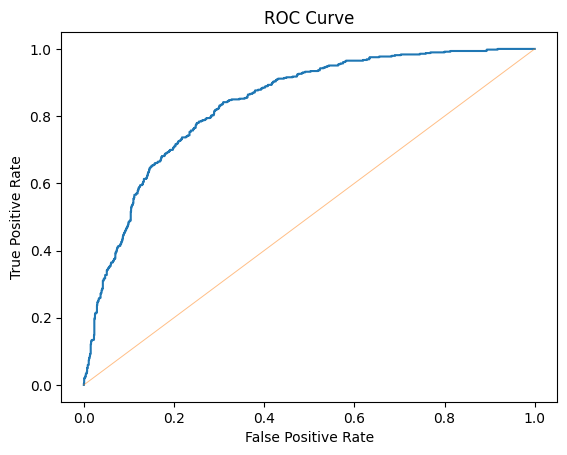

In [241]:
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], lw=0.7, alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve")

plt.show()

Let's try to make more sense of the curve and understand what it can actually tell us. To do this, we visually map the TPR and FPR values to their thresholds on the ROC curve.

In the ROC plot, we start from the (0, 0) point—this is the point at the bottom left. It corresponds to 0% FPR and 0% TPR, which happens at high thresholds like 1.0, when no customers are above that score. For these cases we simply end up predicting “no churn” for everyone. That’s why our TPR is 0%: we are never correctly predicting churned customers. FPR, on the other hand, is 0% because this dummy model can correctly predict all non-churning customers as non-churning, so there are no false positives.

The ROC curve of a good model first goes up as high as it can and only then starts turning right. Poor models, on the other hand, from the start have higher FPRs and lower TPRs, so their curves tend to go to the right earlier.

We can use this for comparing multiple models: we can simply plot them on the same graph and see which of them is closer to the ideal point of (0, 1).

ROC curves are quite useful on their own, but we also have another metric that's based on it: AUC, or the area under the ROC curve.

### 4.3.6. Area under the ROC curve (AUC)

When evaluating our models using the ROC curve, we want them to be as close to the ideal spot and as far from the random baseline as possible.

We can quantify this "closeness" by measuring the area under the ROC curve. We can use this metric-abbreviated as AU ROC, or often simply AUC-as a metric for evaluating the performance of a binary classification model.

Our models will have an AUC between 50% (random baseline) and 100% (ideal curve).

An AUC of 0.9 is indicative of a reasonably good model; 0.8 is okay, 0.7 is not very good, and 0.6 is a poor performer.

To calculate the AUC for our models we can use auc, a function from the metrics package of Scikit-learn:

In [242]:
from sklearn.metrics import auc

In [243]:
auc(df_scores["false_positive_rate"], df_scores["true_positive_rate"])

np.float64(0.8359001084215382)

For the large model, the result is 0.84. Churn prediction is a complex problem, so an AUC of 84% is quite good.

If all we need is the AUC, we don’t need to compute the ROC curve first. We can take a shortcut and use the roc_auc_score function from Scikit-learn, which takes care of everything and simply returns the AUC of our model:

In [244]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

np.float64(0.8363366398907399)

We get approximately the same results as previously.

The values from roc_auc_score may be slightly different from AUC computed from the dataframes where we calculated TPR and FPR ourselves: Scikit-learn internally uses a more precise method for creating ROC curves.

ROC curves and AUC scores tell us how well the model separates positive and negative examples. What is more, AUC has a nice probabilistic interpretation: it tells us what the probability is that a randomly selected positive example will have a score higher than a randomly selected negative example.

Suppose we randomly pick a customer that we know churned and a customer who didn't and then apply the model to these customers and see what the score is for each. We want the model to score the churning customer higher than the non-churning one. AUC tells us the probability of that happening: it's the probability that the score of a randomly selected churning customer is higher than the score of a randomly selected non-churning one.

AUC not only gives us a way of evaluating the models at all possible thresholds but also describes how well the model separates two classes: in our case, churning and non-churning. If the separation is good, then we can order the customers such that most of the churning users come first. Such a model will have a good AUC score.

You should keep this interpretation in mind: it provides an easy way to explain the meaning behind AUC to people without a machine learning background, such as managers and other decision makers.

This makes AUC the default classification metric in most situations, and it's often the metric we use when finding the best parameter set for our models.

The process of finding the best parameters is called "parameter tuning".

## 4.4. Parameter tuning

How do we check if the model indeed works well in a consistent and predictable manner?

### 4.4.1. K-fold cross-validation

It's possible to use all the available data to assess the quality of models and get more reliable validation results. We can simply perform validation multiple times.

First, we split the entire dataset into a certain number of parts (say, three). Then we train a model on two parts and validate on the remaining one. We repeat this process three times and at the end get three different scores. This is exactly the idea behind K-fold cross-validation.

Before we implement it, we need to make the training process simpler, so it's easy to run this process multiple times. For that, we'll put all the code for training into a train function, which first converts the data into a one-hot encoding representation and then trains the model.

In [245]:
def train(df, y):
    # the 4 lines below applies one-hot encoding
    cat = df[categorical + numerical].to_dict(orient="records")
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    # the 2 lines below train the model
    model = LogisticRegression(solver="liblinear")
    model.fit(X, y)

    return dv, model

Likewise, we also put the prediction logic into a predict funtion. This function takes in a dataframe with customers, the vectorizer we "trained" previously-for doing one-hot encoding-and the model. Then we apply the vectorizer to the dataframe, get a matrix, and finally apply the model to the matrix to get predictions.

In [246]:
def predict(df, dv, model):
    # applies the same one-hot encoding scheme as in the train function
    cat = df[categorical + numerical].to_dict(orient="records")
    
    X = dv.transform(cat)

    # uses the model to make predictions
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

Now wew can use these functions for implementing K-fold cross-validation. 

We don't need to implement cross-validation ourselves: in Scikit-learn there's a class for doing that. It's called KFold, and it lives in the model_selection package.

In [247]:
from sklearn.model_selection import KFold

In [248]:
# this splits the data into 10 parts
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# n_splits is essentially k, which specifies the number of splits

# this creates a list for storing the reuslts
aucs = []

# iterates over the 10 different splits of the data
for train_idx, val_idx in kfold.split(df_train_full):
    # splits the data into train and validation sets
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train["churn"].values
    y_val = df_val["churn"].values
    # trains the model and makes predictions
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    # evaluates the quality of the train model on the validation data using AUC
    auc = roc_auc_score(y_val, y_pred)
    # saves the AUC to the list with the results
    aucs.append(auc)

Here we used K-fold cross-validation with K=10. Thus, when re run it, at the end we get 10 different numbers-10 AUC scores evaluated on 10 different validation folds:

In [249]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.841, 0.844, 0.822, 0.845,
       0.861])

It’s not a single number anymore, and we can think of it as a distribution of AUC scores for our model. We can get some statistics from this distribution, such as the mean and standard deviation:

In [250]:
print("auc = %0.3f ± %0.3f" % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


Now, not only do we know the average performance, but we also have an idea of how volatile that performance is, or how far it may deviate from the average.

A good model should be quite stable across different folds: this way, we make sure we don’t get a lot of surprises when the model goes live. The standard deviation tells us about that: the smaller it is, the more stable the model is.

Now, we can use K-fold cross-validation for parameter tuning: selecting the best parameter

### 4.4.2. Finding best parameters

We learned how we can use K-fold cross-validation for evaluating the performance of our model. The model we trained previously was using the default value for the parameter c, which controls the amount of regularization.

Let's select our cross-validation procedure for selecting the best parameter c. For that, we first adjust the train function to take in an additional parameter.

In [251]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient="records")
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver="liblinear", C=C)
    model.fit(X, y)

    return dv, model

Now let's find the best parameter c. The idea is simple:

- Loop over different values of c.
- For each c, run cross-validation and record the mean AUC across all folds as well as the standard deviation.

In [252]:
nfolds = 5

kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
    
        y_train = df_train["churn"].values
        y_val = df_val["churn"].values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print("C=%s, auc = %0.3f ± %0.3f" % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.008
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


What we see is that after C = 0.1, the average AUC is the same and doesn’t grow anymore.

However, the standard deviation is smaller for C = 0.5 than for C = 0.1, so we should use that. The reason we prefer C = 0.5 to C = 1 and C = 10 is simple: when the C parameter is small, the model is more regularized. The weights of this model are more restricted, so in general, they are smaller. Small weights in the model give us additional assurance that the model will behave well when we use it on real data. So we select C = 0.5.

Now we need to do the last step: train the model on the entire train and validation datasets and apply it to the test dataset to verify it indeed works well.

Let's use our train and predict functions for that:

In [253]:
y_train = df_train_full["churn"].values
y_test = df_test["churn"].values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print("auc = %.3f" % auc)

auc = 0.858


When we execute the code, we see that the performance of the model (AUC) on the held-out test set is 0.858.

That's a little higher than what we had on the validation set, but that's not an issue: it could happen just by chance. What's important is that the score is not significantly different from the validation score.

Now we can use this model for scoring real customers and think about our marketing campaign for preventing churn.

Answers:
- Exercise 4.1 = b
- Exerciss 4.2 = b
- Exercise 4.3 = a
- Exercise 4.4 = a